# Fall 2025 ASTR 8750 Project

## 4FGL Blazar ML Classification and Cross Validation

**Reference:** https://github.com/srinadh99/Astronomical-Source-Classification-using-Machine-Learning/blob/main/MLAlgos/Ex1_SG_MLAlgos_PF.ipynb

In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# set random seed for reproducibility
np.random.seed(1234)


Load and filter data for classification

In [34]:
df = pd.read_csv("blazar_catalog_v35_features.csv")

# Filter 'bll' and 'fsrq' labeled sources for training
df["CLASS1"] = df["CLASS1"].str.lower()
df_labeled = df[df["CLASS1"].isin(['bll', 'fsrq'])].copy()
df_bcu = df[df["CLASS1"]=='bcu'].copy()
print("Classification Task Summary:")
print(f"\t Total sources   : {len(df)}")
print(f"\t Labeled sources : {len(df_labeled)}")
print(f"\t Unknown sources : {len(df_bcu)}")

# Set missing feature values (Median)
numerical_cols = df_labeled.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df_labeled[col].fillna(df_labeled[col].median(), inplace=True)

# Separate Features (X) and Target (y)
drop_cols = ["Source_Name", "ASSOC_FGL", "ASSOC1", "CLASS1"]
X = df_labeled.drop(columns=drop_cols).values
y_raw = df_labeled["CLASS1"].values
# set 'bll' = 0 and 'fsrq' = 1
y, label_strings = pd.factorize(y_raw, sort=True)

Classification Task Summary:
	 Total sources   : 3933
	 Labeled sources : 2310
	 Unknown sources : 1623


Create Train/Val/Test sets

In [35]:
# Test size is set to 20% of the labeled data and remaining is used for training and validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Split the training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
print(f"Train shape : {X_train.shape}")
print(f"Val shape   : {X_val.shape}")
print(f"Test shape  : {X_test.shape}") 

Train shape : (1386, 16)
Val shape   : (462, 16)
Test shape  : (462, 16)


Metrics function (copied from Srinadh's git)

In [36]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

Classify the unknown blazar types `"CLASS1" == 'bcu'`, using ML Algorithms
### 1. Decision Tree

Best Estimator: DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=0)
Best CV Score: 0.8836680583022046
Identified 415 correct labels out of 462 labels
Accuracy: 0.8982683982683982
Precision: 0.8981859410430839
Recall: 0.8772712391553446
F1 Score: 0.886101246833086
Labels are: ['bll' 'fsrq']
Confusion Matrix:
 [[283  15]
 [ 32 132]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       298
           1       0.90      0.80      0.85       164

    accuracy                           0.90       462
   macro avg       0.90      0.88      0.89       462
weighted avg       0.90      0.90      0.90       462



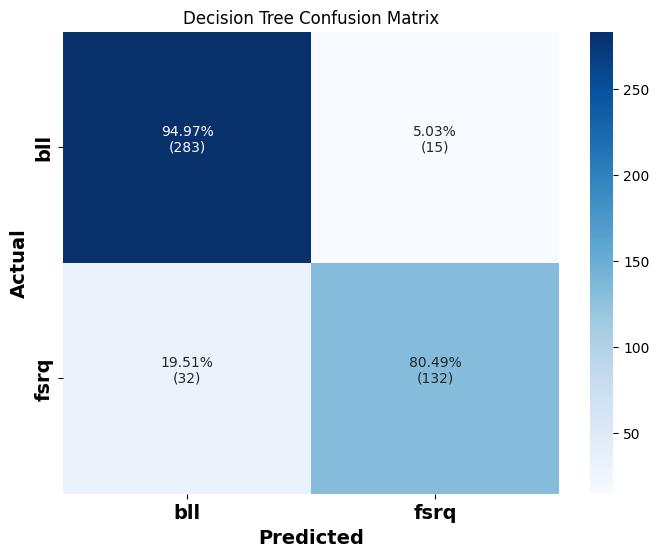

In [37]:
# Stacking training and validation datasets for corss validation
X_train_cv = np.vstack((X_train, X_val))
y_train_cv = np.hstack((y_train, y_val))

# Grid search
tuning_parameters_dt = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [5, 10, 20, 50],
    'min_samples_split' : [5, 10, 20]
}

DT = GridSearchCV(DecisionTreeClassifier(random_state=0), tuning_parameters_dt, cv=5, scoring='accuracy', return_train_score=True)
DT.fit(X_train_cv, y_train_cv)  # DT grid search on combined test and validation set

print(f"Best Estimator: {DT.best_estimator_}")
print(f"Best CV Score: {DT.best_score_}")

# Predict on test
y_test_pred_dt = DT.predict(X_test)

# Print Decision Tree result
DT_metrics = get_metrics(y_test_pred_dt, y_test, label_strings)

# Plot Confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_dt)
cf_matrix_percentage = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:0.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.xaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Save model
with open("Blazar_DT_Model.pkl", 'wb') as f:
    pickle.dump(DT, f)

### 2. Random Forest

Best Estimator: RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50,
                       random_state=0)
Best CV Score: 0.902064015234747
Identified 414 correct labels out of 462 labels
Accuracy: 0.8961038961038961
Precision: 0.8901458019105077
Recall: 0.8810770993615976
F1 Score: 0.8852649006622517
Labels are: ['bll' 'fsrq']
Confusion Matrix:
 [[278  20]
 [ 28 136]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       298
           1       0.87      0.83      0.85       164

    accuracy                           0.90       462
   macro avg       0.89      0.88      0.89       462
weighted avg       0.90      0.90      0.90       462



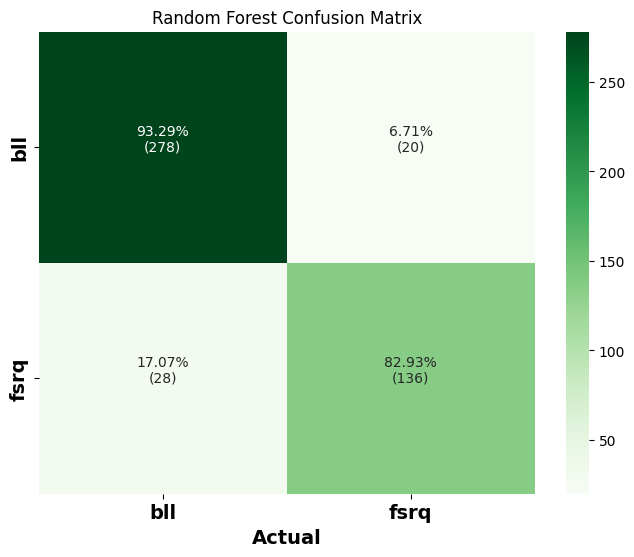

In [38]:
# Grid search
tuning_parameters_rf = {
    'n_estimators' : [50, 100, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 20],
    'min_samples_split' : [5, 10]
}

RF = GridSearchCV(RandomForestClassifier(random_state=0), tuning_parameters_rf, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
RF.fit(X_train_cv, y_train_cv)  # RF grid search on combined test and validation set

print(f"Best Estimator: {RF.best_estimator_}")
print(f"Best CV Score: {RF.best_score_}")

# Predict on test
y_test_pred_rf = RF.predict(X_test)

# Print Random Forest result
RF_metrics = get_metrics(y_test_pred_rf, y_test, label_strings)

# Plot Confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_rf)
cf_matrix_percentage = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:0.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xlabel('Actual', fontsize=14, weight='bold')
ax.xaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Save model
with open("Blazar_RF_Model.pkl", 'wb') as f:
    pickle.dump(RF, f)

### 3. XGBoost (GBDT)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)
Best CV Score: 0.8966542151908005
Identified 418 correct labels out of 462 labels
Accuracy: 0.9047619047619048
Precision: 0.8998240321769733
Recall: 0.8905303650351939
F1 Score: 0.8948261589403974
Labels are: [

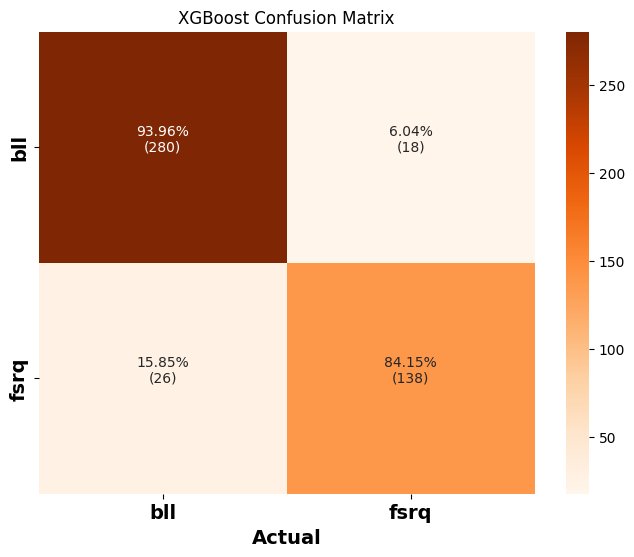

In [39]:
# Grid search
tuning_parameters_gbdt = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [3, 5, 10],
    'learning_rate' : [0.01, 0.1, 0.2]
}

GBDT = GridSearchCV(XGBClassifier(random_state=0, eval_metric='logloss'), tuning_parameters_gbdt, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
GBDT.fit(X_train_cv, y_train_cv)  # GBDT grid search on combined test and validation set

print(f"Best Estimator: {GBDT.best_estimator_}")
print(f"Best CV Score: {GBDT.best_score_}")

# Predict on test
y_test_pred_gbdt = GBDT.predict(X_test)

# Print Random Forest result
GBDT_metrics = get_metrics(y_test_pred_gbdt, y_test, label_strings)

# Plot Confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_gbdt)
cf_matrix_percentage = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:0.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xlabel('Actual', fontsize=14, weight='bold')
ax.xaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(label_strings, fontsize=14, weight='bold')
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save model
with open("Blazar_GBDT_Model.pkl", 'wb') as f:
    pickle.dump(GBDT, f)

### Compare the three classification algorithm's performance metrics and determine the best model for blazar classification.
Use the best model to predict the blazar class.

In [ ]:
# Best model has the highest accuracy
model_metrics = {
    DT : DT_metrics,
    RF : RF_metrics,
    GBDT : GBDT_metrics
}
# Model metrics order: correct_labels, accuracy, precision, recall, confusion_matrix, classification_report
best_model = max(model_metrics, key=lambda k:model_metrics[k][1])
best_accuracy = model_metrics[best_model][1]

print(f"The best model is {str(best_model.best_estimator_)} with an accuracy of {best_accuracy:.4f}")

print(f"Predicting classes for {len(df_bcu)} BCU sources...")
X_bcu = df_bcu.drop(columns=drop_cols).values

# Class predictions and probabilities
bcu_preds = best_model.predict(X_bcu)
bcu_probs = best_model.predict_proba(X_bcu)

# Reassign labels, 0 = 'bll' and 1 = 'fsrq'
predicted_labels = [label_strings[p] for p in bcu_preds]

# Create Results DataFrame
results = df_bcu[["Source_Name"]].copy()
results['Pred_CLASS1'] = predicted_labels

results['Confidence_FSRQ'] = bcu_probs[:, 1] 
results['Confidence_BLL'] = bcu_probs[:, 0]

output_filename = 'final_bcu_predictions.csv'
results.to_csv(output_filename, index=False)
print(f"Prediction saved to {output_filename}")

The best model is XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...) with an accuracy of 0.9048
Predicting classes for 1623 BCU sources...
Prediction saved to final_bcu_predictions.csv
